# Gradient Boosting Trees

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


# Instruments

In [3]:
from constants import *

TARGET_FUT, INTERVAL

('ZC', '15m')

## Data Load

In [4]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
futs_df.head(2)

./data/\futures_15m.csv
(4224, 144)


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Spread,CL_Open,CL_High,CL_Low,CL_Close,...,ZW_Low,ZW_Close,ZW_Volume,ZW_Spread,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Close,^VIX_Volume,^VIX_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-24 22:16:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.849998,80.910004,80.589996,80.699997,...,555.75,556.25,494,4.25,13.67,13.67,13.65,13.65,0.0,0.02
2024-03-24 22:31:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.849998,80.910004,80.589996,80.699997,...,555.75,556.25,494,4.25,13.67,13.67,13.65,13.65,0.0,0.02


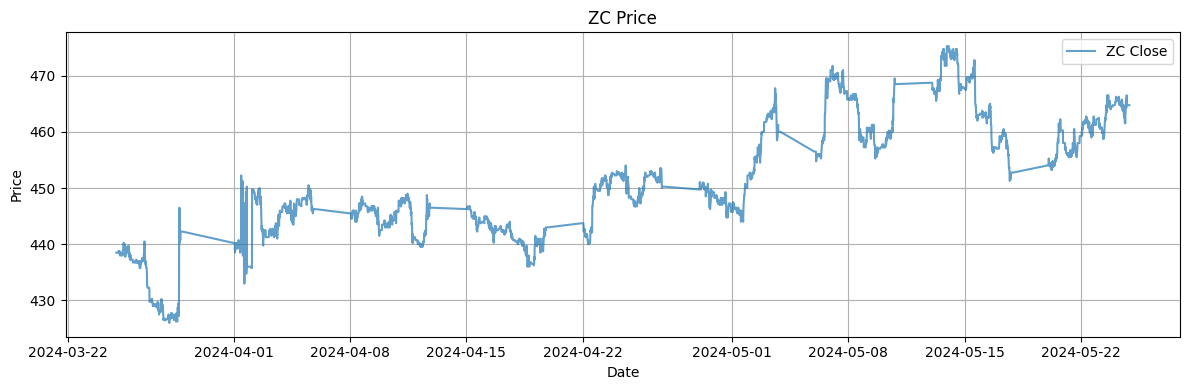

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
target_fut_df = futs_df[
    [item for f in MARKET_FUTS + AGRI_FUTS for item in [f"{f.replace('=F', '')}_Close", f"{f.replace('=F', '')}_High", f"{f.replace('=F', '')}_Low", f"{f.replace('=F', '')}_Open", f"{f.replace('=F', '')}_Volume"]]
]

target_fut_df.tail(5)

,ES_Close,ES_High,ES_Low,ES_Open,ES_Volume,NQ_Close,NQ_High,NQ_Low,NQ_Open,NQ_Volume,...,GF_Close,GF_High,GF_Low,GF_Open,GF_Volume,DC_Close,DC_High,DC_Low,DC_Open,DC_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-24 21:01:00+00:00,5325.25,5327.75,5321.75,5322.0,24282.0,18915.25,18923.25,18900.0,18903.25,11006.0,...,260.424988,260.424988,260.075012,260.125,209,19.889999,19.969999,18.57,19.969999,151
2024-05-24 21:16:00+00:00,5325.25,5327.75,5321.75,5322.0,24282.0,18915.25,18923.25,18900.0,18903.25,11006.0,...,260.424988,260.424988,260.075012,260.125,209,19.889999,19.969999,18.57,19.969999,151
2024-05-24 21:31:00+00:00,5325.25,5327.75,5321.75,5322.0,24282.0,18915.25,18923.25,18900.0,18903.25,11006.0,...,260.424988,260.424988,260.075012,260.125,209,19.889999,19.969999,18.57,19.969999,151
2024-05-24 21:46:00+00:00,5325.25,5327.75,5321.75,5322.0,24282.0,18915.25,18923.25,18900.0,18903.25,11006.0,...,260.424988,260.424988,260.075012,260.125,209,19.889999,19.969999,18.57,19.969999,151
2024-05-24 22:00:00+00:00,5325.25,5327.75,5321.75,5322.0,24282.0,18915.25,18923.25,18900.0,18903.25,11006.0,...,260.424988,260.424988,260.075012,260.125,209,19.889999,19.969999,18.57,19.969999,151


# Prepare the Data

In [7]:
from signals import dynamic_support_resistance, kalman_backtest, signal_kf_bollinger_bands
from quant_equations import get_ou, modulate_std

HALF_LIFE, HURST = get_ou(target_fut_df, f"{TARGET_FUT}_Close")

window = abs(HALF_LIFE)
bb_df = signal_kf_bollinger_bands(target_fut_df, f"{TARGET_FUT}_Close", f"{TARGET_FUT}_Volume", std_factor=modulate_std(HURST))

spread = bb_df["%B"].bfill().ffill()
volumes = target_fut_df[f"{TARGET_FUT}_Volume"].to_numpy()
prices = target_fut_df[f"{TARGET_FUT}_Close"].to_numpy()

assert not np.isnan(spread).any() and not np.isnan(volumes).any()

big_fut_df, _, _ = dynamic_support_resistance(futs_df, f"{TARGET_FUT}_Close", f"{TARGET_FUT}_High",f"{TARGET_FUT}_Low",window_size=HALF_LIFE)
kf_df, _ = kalman_backtest(spread, volumes, prices, period=INTERVAL)

big_fut_df = pd.concat([big_fut_df, kf_df], axis=1).bfill().ffill()
big_fut_df.tail(5)

100%|██████████| 3802/3802 [00:01<00:00, 2472.20it/s]
kalman_backtest: 3802it [00:00, 6122.44it/s]


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Spread,CL_Open,CL_High,CL_Low,CL_Close,...,SB,SS,SBS,SSB,Closed,Position,Ret,Unreal_Ret,cRets,Drawdown
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-24 21:01:00+00:00,4.463,4.463,4.458,4.458,48.0,0.005,77.790001,77.940002,77.769997,77.889999,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.251642,-0.097866
2024-05-24 21:16:00+00:00,4.463,4.463,4.458,4.458,48.0,0.005,77.790001,77.940002,77.769997,77.889999,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.251642,-0.097866
2024-05-24 21:31:00+00:00,4.463,4.463,4.458,4.458,48.0,0.005,77.790001,77.940002,77.769997,77.889999,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.251642,-0.097866
2024-05-24 21:46:00+00:00,4.463,4.463,4.458,4.458,48.0,0.005,77.790001,77.940002,77.769997,77.889999,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.251642,-0.097866
2024-05-24 22:00:00+00:00,4.463,4.463,4.458,4.458,48.0,0.005,77.790001,77.940002,77.769997,77.889999,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.251642,-0.097866


## Meta Label

In [8]:
import pandas as pd
from tqdm import tqdm

META_LABEL = "mr_label"

big_fut_df[META_LABEL] = 0
position = 0
start_index = None
entry_price = 0

for i, row in tqdm(big_fut_df.iterrows(), desc="Posthoc Metalabeling"):
    if row['Closed'] != 0:
        # Position closed, work backwards
        ret = row['Ret']
        metalabel = 1 if ret > 0 else -1
        if start_index is not None:
            big_fut_df.loc[start_index:row.name, META_LABEL] = metalabel

        position = 0
        start_index = None
        entry_price = 0

    if row['Position'] != 0 and position == 0:
        # New position opened
        position = row['Position']
        start_index = row.name
        entry_price = row[f"{TARGET_FUT}_Close"]

metalabel_df = big_fut_df[[f"{TARGET_FUT}_Close", 'Position', "Ret", 'Z1', 'Z2', 'X', META_LABEL]]
metalabel_df[metalabel_df[META_LABEL] != 0]

Posthoc Metalabeling: 4224it [00:00, 43874.28it/s]


,ZC_Close,Position,Ret,Z1,Z2,X,mr_label
Date,,,,,,,
2024-04-01 09:01:00+00:00,439.00,1.0,0.00000,-0.174053,-0.026270,0.063690,1
2024-04-01 09:16:00+00:00,438.50,1.0,0.00000,-0.138205,-0.014129,0.045236,1
2024-04-01 09:31:00+00:00,439.25,1.0,0.00000,0.051709,0.024247,0.519308,1
2024-04-01 09:46:00+00:00,439.50,1.0,0.00000,0.122125,0.033362,0.606480,1
2024-04-01 10:01:00+00:00,439.00,1.0,0.00000,0.080326,0.018540,0.351871,1
...,...,...,...,...,...,...,...
2024-05-24 15:46:00+00:00,462.25,1.0,0.00000,0.000369,0.013002,-0.038095,1
2024-05-24 16:01:00+00:00,461.50,1.0,0.00000,-0.031775,-0.000151,-0.194483,1
2024-05-24 16:16:00+00:00,462.75,1.0,0.00000,0.161042,0.057614,0.148852,1


# Data Clean

In [9]:
UNIVERSE_COLS = np.array(target_fut_df.columns)
KF_COLS = ['Z1', 'Z2', 'Filtered_X', 'Uncertainty', 'Residuals', 'KG_X', 'KG_Z1', 'KG_Z2']
BB_COLS = ['SB','SS','SBS','SSB', 'Unreal_Ret'] # 'MA','SD', 'U','L',
SR_COLS = ["PP", "S1", "R1", "S2", "R2", "Support", "Resistance"]

CORR_THRESHOLD = 0.95

all_columns = np.concatenate([UNIVERSE_COLS, np.array(KF_COLS), np.array(BB_COLS), np.array(SR_COLS)])

big_fut_df[META_LABEL] = big_fut_df[META_LABEL] > 0  # Set to binary (lose = 0, win = 1)
y = big_fut_df[META_LABEL]

X = big_fut_df[all_columns]
X = X.loc[:, ~X.columns.duplicated()]

"""
from sklearn.preprocessing import StandardScaler
# Scaling didn't change performance.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
"""

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > CORR_THRESHOLD)]
"""
# VIF does a better job.
X = X.drop(columns=to_drop)
"""

print(f"These are highly corr: {to_drop}")

These are highly corr: ['ES_High', 'ES_Low', 'ES_Open', 'NQ_Close', 'NQ_High', 'NQ_Low', 'NQ_Open', 'NQ_Volume', '^VIX_High', '^VIX_Low', '^VIX_Open', 'RTY_High', 'RTY_Low', 'RTY_Open', '10Y_High', '10Y_Low', '10Y_Open', 'ZC_High', 'ZC_Low', 'ZC_Open', 'ZL_High', 'ZL_Low', 'ZL_Open', 'KE_High', 'KE_Low', 'KE_Open', 'ZS_High', 'ZS_Low', 'ZS_Open', 'ZM_High', 'ZM_Low', 'ZM_Open', 'ZW_Close', 'ZW_High', 'ZW_Low', 'ZW_Open', 'LE_High', 'LE_Low', 'LE_Open', 'HE_High', 'GF_High', 'GF_Open', 'DC_High', 'DC_Low', 'DC_Open', 'KG_Z2', 'PP', 'S1', 'R1', 'S2', 'R2', 'Support']


In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

VIF_THRESHOLD = 10.

def calculate_vif(X):
    x_const = add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["feature"] = x_const.columns
    vif_data["VIF"] = [
        variance_inflation_factor(x_const.values, i)
        for i in range(x_const.shape[1])
    ]
    return vif_data

vif_data = calculate_vif(X)
vif_data = vif_data.sort_values(by="VIF", ascending=False)

vif_data = vif_data.replace([np.inf, -np.inf], np.nan).dropna()
acceptable_vif = vif_data[vif_data["VIF"] < VIF_THRESHOLD]
selected_features = acceptable_vif["feature"].tolist()
if 'const' in selected_features:
    selected_features.remove('const')

X = X[selected_features]
print(f"Multi-Colinear: {vif_data[vif_data['VIF'] >= VIF_THRESHOLD]['feature'].values}")

Multi-Colinear: ['const' 'ES_Low' 'ES_High' 'ES_Close' 'NQ_Low' 'ES_Open' 'NQ_High'
 'NQ_Close' 'NQ_Open' 'RTY_Low' 'ZW_Low' 'RTY_High' 'RTY_Close' 'ZM_High'
 'ZW_High' 'ZM_Low' 'RTY_Open' 'ZM_Close' 'ZM_Open' '10Y_High' 'KE_Low'
 '10Y_Low' '10Y_Close' 'ZL_Low' 'ZW_Close' 'ZL_High' '10Y_Open' '^VIX_Low'
 '^VIX_Close' 'KE_High' '^VIX_High' 'ZL_Close' '^VIX_Open' 'ZW_Open'
 'KE_Open' 'ZS_High' 'ZS_Low' 'KE_Close' 'ZL_Open' 'ZS_Close' 'ZS_Open'
 'KG_Z1' 'LE_Low' 'KG_Z2' 'LE_Close' 'ZC_Open' 'LE_High' 'LE_Open'
 'HE_Close' 'HE_High' 'GF_High' 'GF_Close' 'Support' 'DC_Close' 'KG_X'
 'DC_Open' 'DC_High' 'ES_Volume' 'GF_Low' 'GF_Open' 'HE_Open' 'HE_Low'
 'NQ_Volume' 'DC_Low' 'Resistance' 'Uncertainty' 'RTY_Volume']


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GBC

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

def param_search():
    # Best parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
    model = GradientBoostingClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='precision', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best precision score: {grid_search.best_score_}")

    best_model = grid_search.best_estimator_
    return best_model

PARAM_SEARCH = True
if PARAM_SEARCH:
    best_model = param_search()
else:
    best_model = GradientBoostingClassifier(random_state=42, learning_rate=0.01, max_depth=3, n_estimators=100)
    best_model.fit(X_train, y_train)
best_model

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best precision score: 0.8273465620005337


GradientBoostingClassifier(learning_rate=0.2, random_state=42)

              precision    recall  f1-score   support

       False       0.95      0.99      0.97       742
        True       0.88      0.59      0.71       103

    accuracy                           0.94       845
   macro avg       0.91      0.79      0.84       845
weighted avg       0.94      0.94      0.94       845



<Figure size 640x480 with 0 Axes>

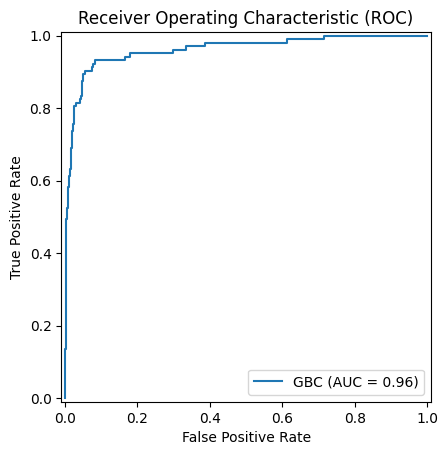

<Figure size 640x480 with 0 Axes>

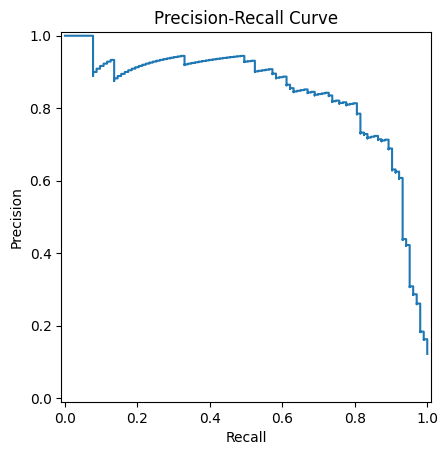

Precision: 0.8841
Recall: 0.5922
F1 Beta Score: 0.9383


In [13]:
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, fbeta_score, precision_score, recall_score, RocCurveDisplay, PrecisionRecallDisplay

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="GBC").plot()
plt.title('Receiver Operating Characteristic (ROC)')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title('Precision-Recall Curve')
plt.show()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = fbeta_score(y_test, y_pred, average='weighted', beta=0.)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Beta Score: {f1:.4f}')

## XAI

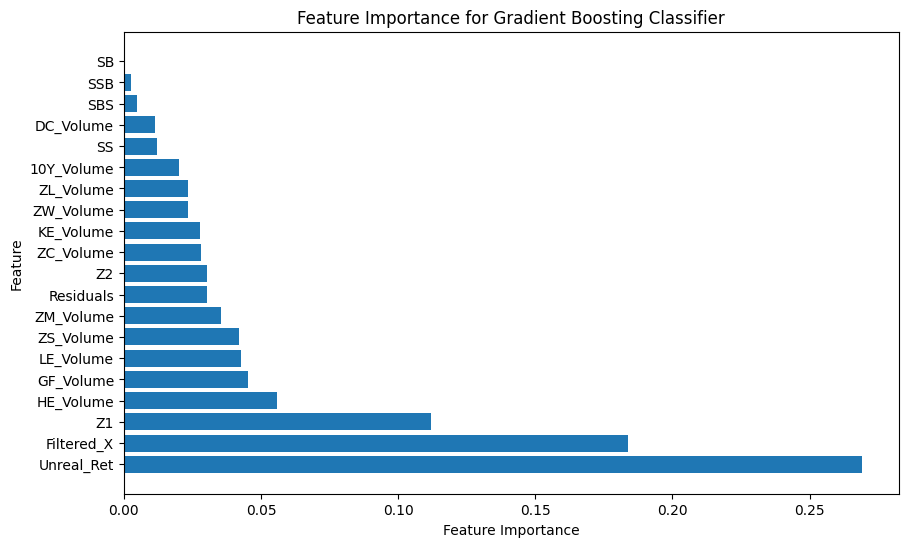

In [14]:
feature_importance = best_model.feature_importances_
features = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'Feature {i}' for i in range(X_train.shape[1])]

# Create a DataFrame for feature importance
gbc_feat_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
gbc_feat_df = gbc_feat_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(gbc_feat_df["Feature"], gbc_feat_df["Importance"], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Gradient Boosting Classifier')
plt.show()

In [74]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_train.values, feature_names=features, class_names=['RW', 'MR'], discretize_continuous=True)
exp = explainer.explain_instance(X_train.iloc[0].values, best_model.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True)

The summary plot provides a global view of feature importance across all predictions. The SHAP value represents the impact of each feature on the model's output. 

Positive SHAP values push the prediction towards one class (mean reversion in your case), while negative SHAP values push it towards the other class (random walk).

The magnitude of the SHAP value indicates the strength of the impact. Larger absolute values mean a stronger impact on the prediction.

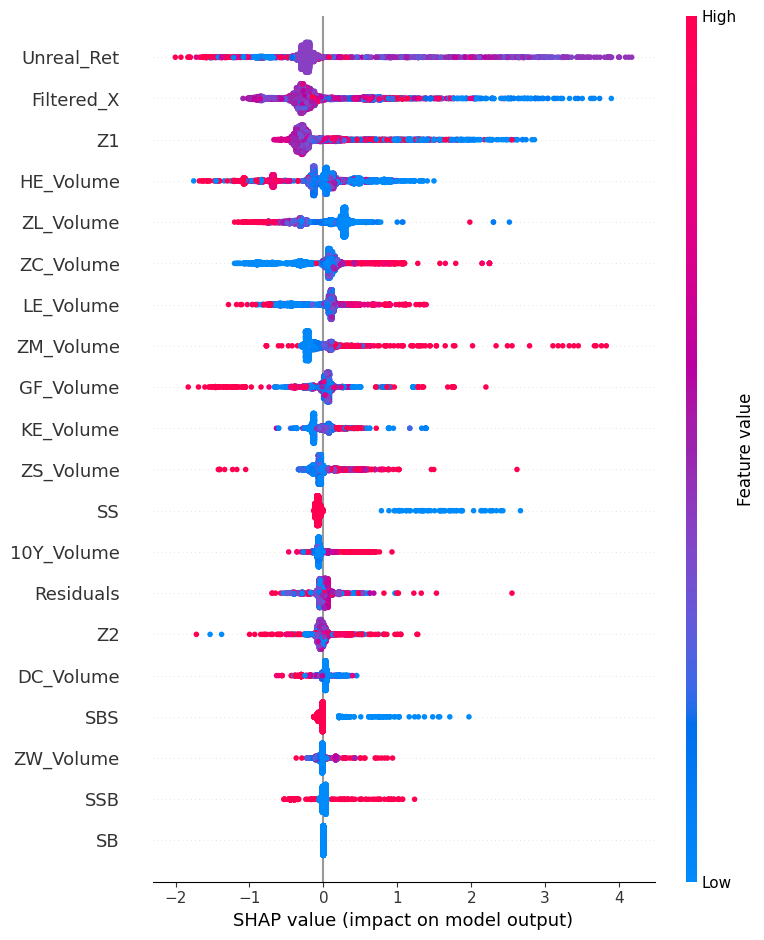

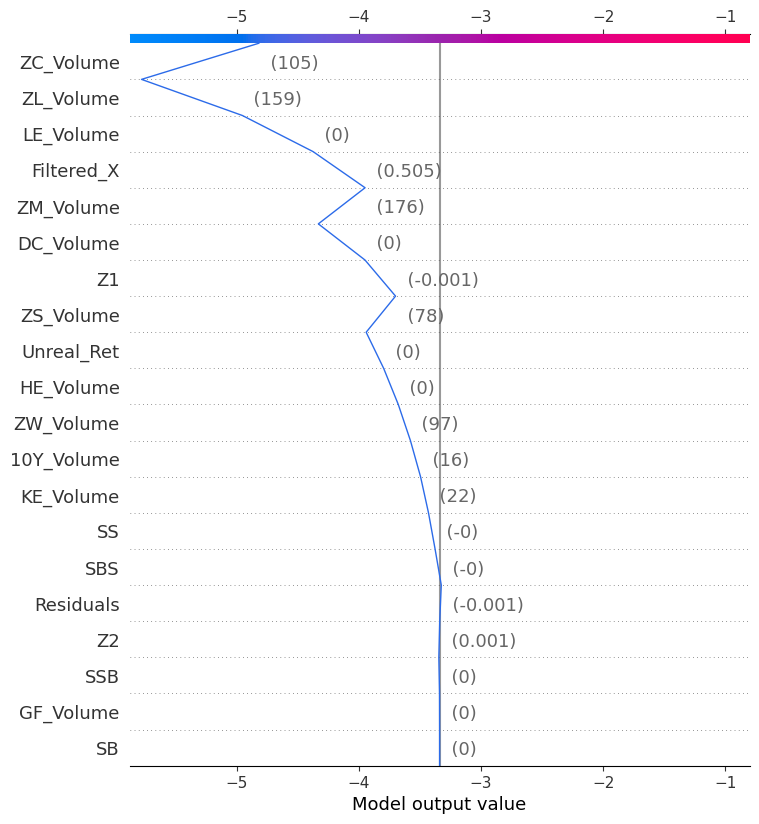

       Feature  Importance
10  Unreal_Ret    0.532733
8   Filtered_X    0.461739
0           Z1    0.399568
11   HE_Volume    0.322922
3    ZL_Volume    0.314682
7    ZC_Volume    0.274714
2    LE_Volume    0.234671
4    ZM_Volume    0.189675
13   GF_Volume    0.144520
9    KE_Volume    0.125990
6    ZS_Volume    0.121583
16          SS    0.102678
15  10Y_Volume    0.086597
12   Residuals    0.077394
1           Z2    0.071779
14   DC_Volume    0.055505


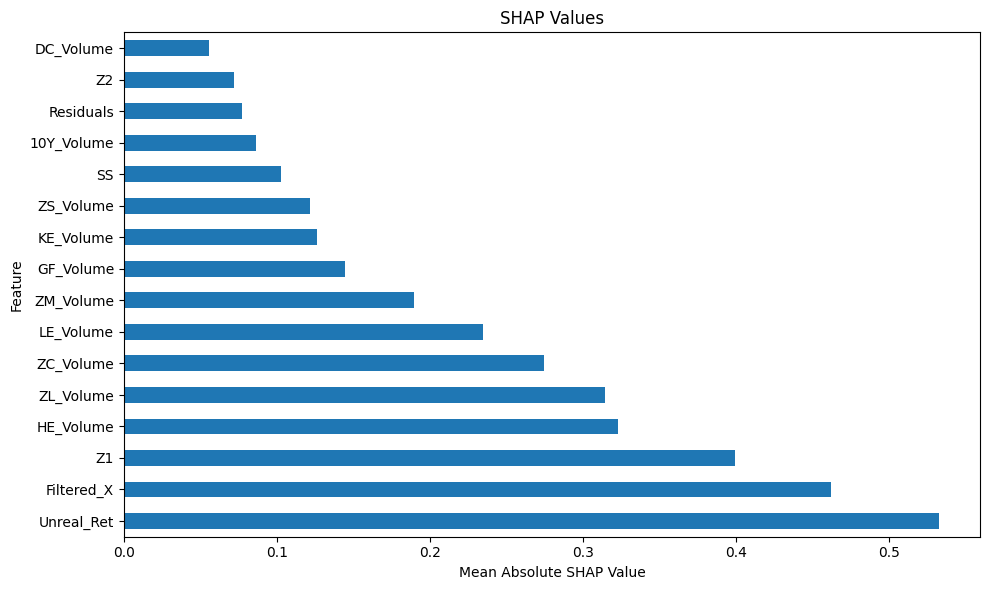

In [15]:
import shap

MAX_FEATURES_COUNT = 16

explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)
shap.decision_plot(explainer.expected_value, shap_values.values[0], X_test.iloc[0])

shap_importance = np.abs(shap_values.values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': shap_importance
})

shap_importance_df = shap_importance_df.sort_values(by='Importance', ascending=False)
top_shap_features = shap_importance_df.head(MAX_FEATURES_COUNT)
print(top_shap_features)

fig, ax = plt.subplots(figsize=(10, 6))
top_shap_features.plot(kind='barh', x='Feature', y='Importance', legend=False, ax=ax)
ax.set_title(f"SHAP Values")
ax.set_xlabel("Mean Absolute SHAP Value")
ax.set_ylabel("Feature")
plt.tight_layout()
plt.show()

## PCA

Max components for 99.0% variance: 8 out of 20


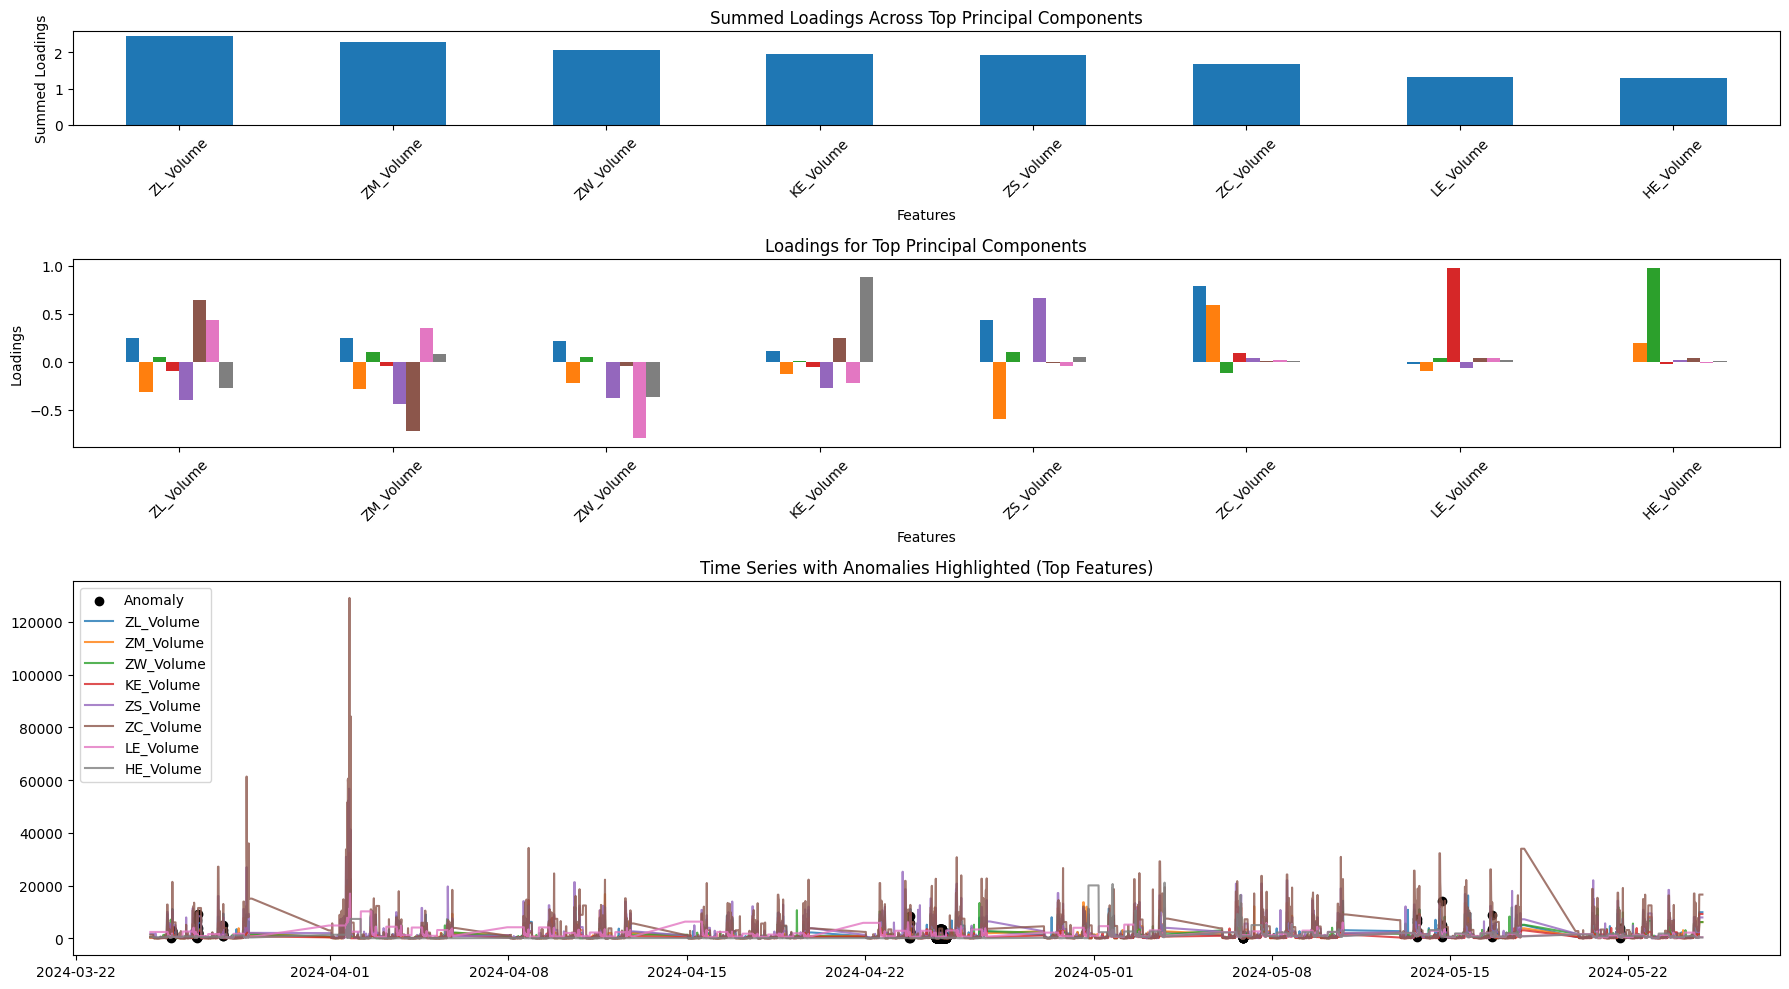

In [16]:
from sklearn.decomposition import PCA

MAX_VARIANCE = 0.99

pca = PCA()
xdata = pca.fit_transform(X)

cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cum_var_exp >= MAX_VARIANCE) + 1
print(f"Max components for {MAX_VARIANCE*100}% variance: {num_components} out of {X.shape[1]}")

pca = PCA(num_components)
xdata = pca.fit_transform(X)
eigenvectors = pca.components_

top_features = np.abs(eigenvectors).sum(axis=0).argsort()[::-1]
selected_features = X.columns[top_features[:num_components]]
loadings_df = pd.DataFrame(eigenvectors[:, top_features[:num_components]], columns=selected_features).T

summed_loadings = np.sum(np.abs(eigenvectors[:, top_features[:num_components]]), axis=0)
summed_loadings_df = pd.DataFrame(summed_loadings, index=selected_features, columns=["Sum"]).sort_values(by="Sum", ascending=False)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 10), gridspec_kw={'height_ratios': [1, 2, 4]})

summed_loadings_df.plot(kind="bar", legend=False, ax=axes[0])
axes[0].set_title("Summed Loadings Across Top Principal Components")
axes[0].set_ylabel("Summed Loadings")
axes[0].set_xlabel("Features")
axes[0].tick_params(axis='x', labelrotation=45)

loadings_df.plot(kind="bar", legend=False, ax=axes[1])
axes[1].set_title(f"Loadings for Top Principal Components")
axes[1].set_ylabel("Loadings")
axes[1].set_xlabel("Features")
axes[1].tick_params(axis='x', labelrotation=45)

xdata_projected = pca.inverse_transform(xdata)
error = np.sum((X - xdata_projected) ** 2, axis=1)
anomaly_threshold = np.percentile(error, MAX_VARIANCE*100)
anomalies = error > anomaly_threshold

data_df_pca = X[selected_features].copy()
anomaly_dates = X.index[np.where(anomalies)]
for i, column in enumerate(data_df_pca.columns):
    axes[2].scatter(anomaly_dates, data_df_pca.loc[anomaly_dates, column], label='Anomaly' if i == 0 else "__nolegend__", color='k')
    axes[2].plot(data_df_pca.index, data_df_pca[column], label=f'{column}', alpha=0.8)
axes[2].set_title('Time Series with Anomalies Highlighted (Top Features)')
axes[2].legend(loc='upper left')
plt.tight_layout()
plt.show()

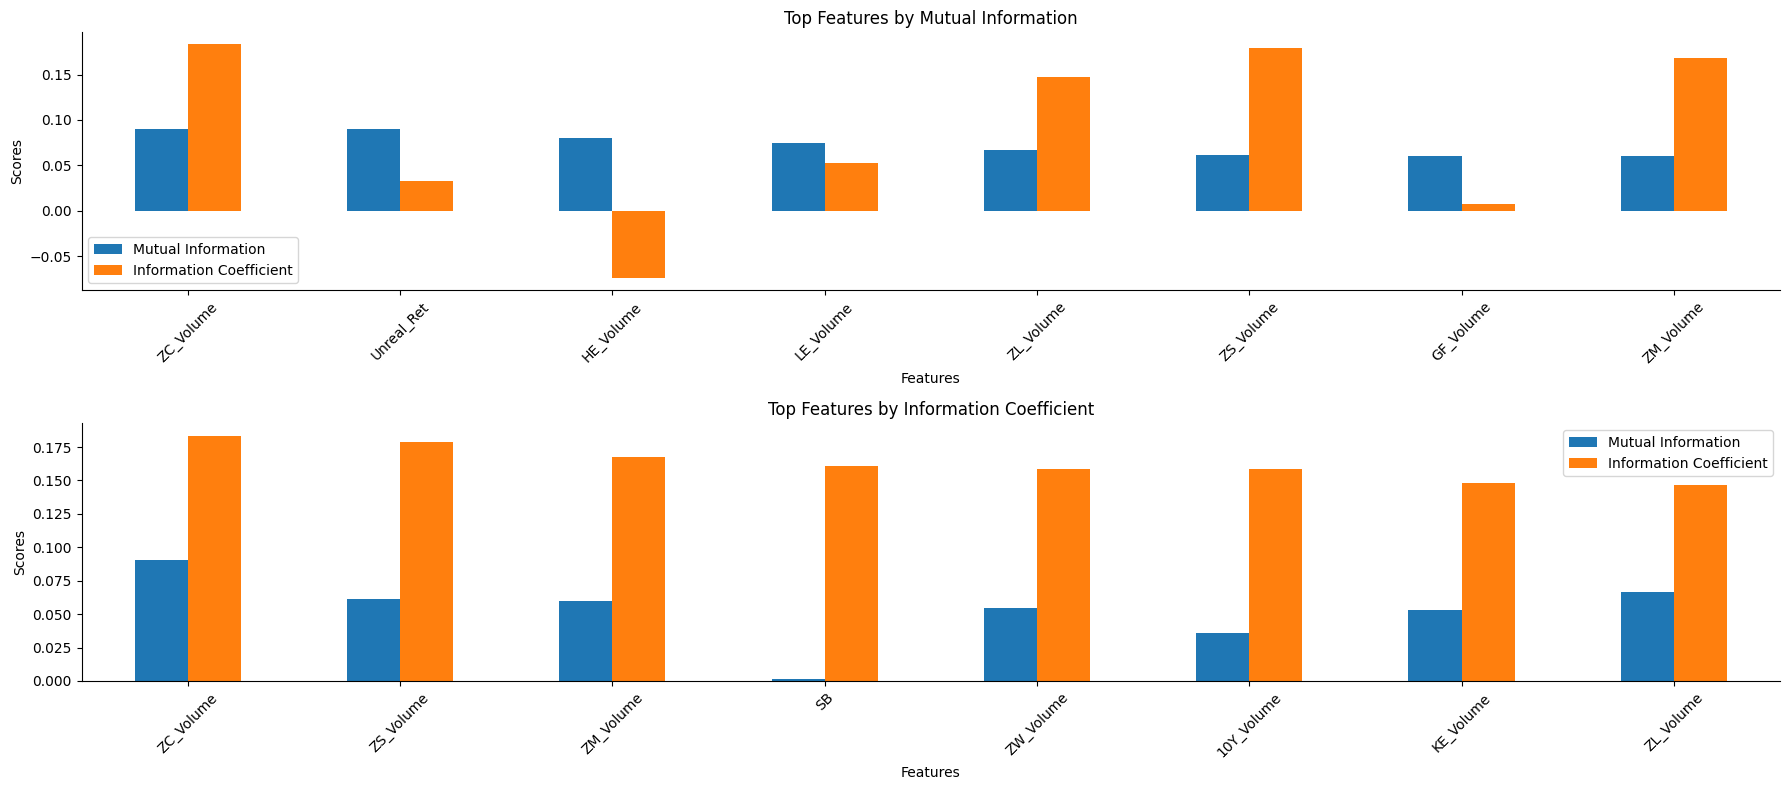

In [17]:
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression

ic = {}
for column in X.columns:
    corr, p_val = spearmanr(big_fut_df[META_LABEL], X[column])
    ic[column] = [corr, p_val]

ic_df = pd.DataFrame(ic, index=["IC", "p-value"]).T

# Calculate Mutual Information (MI)
mi = mutual_info_regression(X=X, y=big_fut_df[META_LABEL])
mi_series = pd.Series(mi, index=X.columns)

# Combine IC and MI into a single DataFrame
metrics = pd.concat(
    [
        mi_series.to_frame("Mutual Information"),
        ic_df["IC"].to_frame("Information Coefficient"),
    ],
    axis=1,
)

# Sort by MI and IC and select top n_components features
top_mi_features = metrics.sort_values(by="Mutual Information", ascending=False).head(num_components)
top_ic_features = metrics.sort_values(by="Information Coefficient", ascending=False).head(num_components)

# Plot the top n_components features based on Mutual Information
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 8))

top_mi_features.plot.bar(ax=axes[0], rot=45)
axes[0].set_xlabel("Features")
axes[0].set_ylabel("Scores")
axes[0].set_title("Top Features by Mutual Information")
axes[0].tick_params(axis='x', labelrotation=45)
sns.despine(ax=axes[0])

# Plot the top n_components features based on Information Coefficient
top_ic_features.plot.bar(ax=axes[1], rot=45)
axes[1].set_xlabel("Features")
axes[1].set_ylabel("Scores")
axes[1].set_title("Top Features by Information Coefficient")
axes[1].tick_params(axis='x', labelrotation=45)
sns.despine(ax=axes[1])

plt.tight_layout()
plt.show()

In [18]:
features_pca = summed_loadings_df.head(MAX_FEATURES_COUNT).index.tolist()
features_miic = (metrics.head(MAX_FEATURES_COUNT).index.tolist())
features_shap  = (shap_importance_df.head(MAX_FEATURES_COUNT)['Feature'].tolist())
features_gbc = (gbc_feat_df.head(MAX_FEATURES_COUNT)['Feature'].tolist())

print(F"Top {MAX_FEATURES_COUNT} PCA Loadings: {features_pca}")
print(F"Top {MAX_FEATURES_COUNT} MI/IC: {features_miic}")
print(F"Top {MAX_FEATURES_COUNT} SHAP: {features_shap}")
print(F"Top {MAX_FEATURES_COUNT} GBC: {features_gbc}")

SELECTED_FEATURES = list(set(features_pca) | set(features_miic) | set(features_shap) | set(features_gbc))

print(f"Selected {len(SELECTED_FEATURES)} features: {SELECTED_FEATURES}")

Top 16 PCA Loadings: ['ZL_Volume', 'ZM_Volume', 'ZW_Volume', 'KE_Volume', 'ZS_Volume', 'ZC_Volume', 'LE_Volume', 'HE_Volume']
Top 16 MI/IC: ['Z1', 'Z2', 'LE_Volume', 'ZL_Volume', 'ZM_Volume', 'ZW_Volume', 'ZS_Volume', 'ZC_Volume', 'Filtered_X', 'KE_Volume', 'Unreal_Ret', 'HE_Volume', 'Residuals', 'GF_Volume', 'DC_Volume', '10Y_Volume']
Top 16 SHAP: ['Unreal_Ret', 'Filtered_X', 'Z1', 'HE_Volume', 'ZL_Volume', 'ZC_Volume', 'LE_Volume', 'ZM_Volume', 'GF_Volume', 'KE_Volume', 'ZS_Volume', 'SS', '10Y_Volume', 'Residuals', 'Z2', 'DC_Volume']
Top 16 GBC: ['Unreal_Ret', 'Filtered_X', 'Z1', 'HE_Volume', 'GF_Volume', 'LE_Volume', 'ZS_Volume', 'ZM_Volume', 'Residuals', 'Z2', 'ZC_Volume', 'KE_Volume', 'ZW_Volume', 'ZL_Volume', '10Y_Volume', 'SS']
Selected 17 features: ['HE_Volume', 'Z2', 'ZW_Volume', 'DC_Volume', 'KE_Volume', 'Z1', 'Unreal_Ret', 'Filtered_X', 'ZL_Volume', 'LE_Volume', 'Residuals', 'ZC_Volume', 'ZS_Volume', 'ZM_Volume', 'GF_Volume', 'SS', '10Y_Volume']


## Refit

In [19]:
X = X[SELECTED_FEATURES]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
if PARAM_SEARCH:
    best_model = param_search()
else:
    best_model = GradientBoostingClassifier(random_state=42, learning_rate=0.01, max_depth=3, n_estimators=100)
    best_model.fit(X_train, y_train)
best_model

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Best precision score: 0.8457671957671957


GradientBoostingClassifier(learning_rate=0.01, max_depth=5, random_state=42)

              precision    recall  f1-score   support

       False       0.89      1.00      0.94       742
        True       1.00      0.07      0.13       103

    accuracy                           0.89       845
   macro avg       0.94      0.53      0.53       845
weighted avg       0.90      0.89      0.84       845



<Figure size 640x480 with 0 Axes>

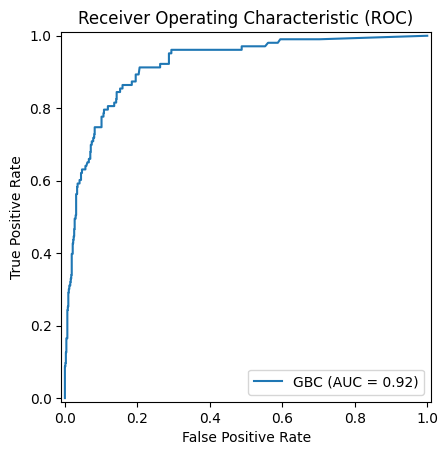

<Figure size 640x480 with 0 Axes>

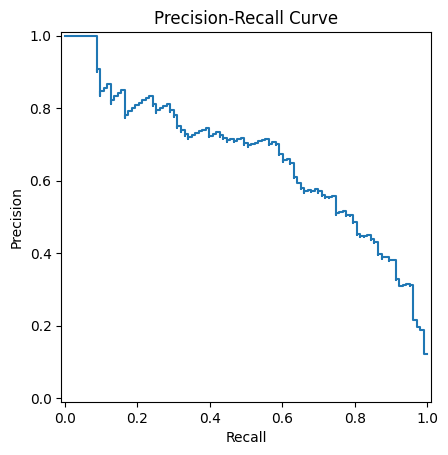

Precision: 1.0000
Recall: 0.0680
F1 Beta Score: 0.8994


In [20]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="GBC").plot()
plt.title('Receiver Operating Characteristic (ROC)')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title('Precision-Recall Curve')
plt.show()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = fbeta_score(y_test, y_pred, average='weighted', beta=0.)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Beta Score: {f1:.4f}')

# Validation

In [72]:
position = 0
start_index = None

big_fut_df['Ret'] = 0
big_fut_df['Closed'] = 0
big_fut_df['Position'] = 0
big_fut_df['Unreal_Ret'] = 0
big_fut_df['cRets'] = 0
for i, row in tqdm(big_fut_df.iterrows(), desc="kalman_backtest"):
    mr_potential = best_model.predict([row[SELECTED_FEATURES]])[0]
    big_fut_df.loc[i, META_LABEL] = mr_potential

    if ((row['SBS'] == -1 and position == 1) or \
        (row['SSB'] == 1 and position == -1) or \
        (position == 1 and row['Close'] <= entry * (1 - 0.2)) or \
        (position == -1 and row['Close'] >= entry * (1 + 0.2))):

        if position == 1:
            big_fut_df.loc[i, 'Ret'] = (row['Close'] - entry) / entry
            big_fut_df.loc[i, 'Closed'] = 1
        else:
            big_fut_df.loc[i, 'Ret'] = (entry - row['Close']) / entry
            big_fut_df.loc[i, 'Closed'] = -1
        position = 0
    elif ((row['SBS'] == 1 and position == 0) or (row['SSB'] == -1 and position == 0)):
        # it was cancelled.
        big_fut_df.loc[i, 'SBS'] = big_fut_df.loc[i, 'SSB'] = 0

    if ((row['SB'] == 1 and position == 0) or (row['SS'] == -1 and position == 0)):
        if mr_potential:
            entry = row['Close']
            position = 1 if row['SB'] == 1 else -1
        else:
            big_fut_df.loc[i, 'SB'] = big_fut_df.loc[i, 'SS'] = 0

    big_fut_df.loc[i, 'Position'] = position
    if position != 0:
        # Unrealized for continuous returns tracking.
        big_fut_df.loc[i, 'Unreal_Ret'] = (entry - row['Close']) / entry

        if not mr_potential:
            if position == 1:
                big_fut_df.loc[i, 'Ret'] = (row['Close'] - entry) / entry
                big_fut_df.loc[i, 'Closed'] = 1
            else:
                big_fut_df.loc[i, 'Ret'] = (entry - row['Close']) / entry
                big_fut_df.loc[i, 'Closed'] = -1
            position = 0

big_fut_df['cRets'] = (1 + big_fut_df['Ret']).cumprod() - 1

kalman_backtest: 4224it [00:14, 281.73it/s]


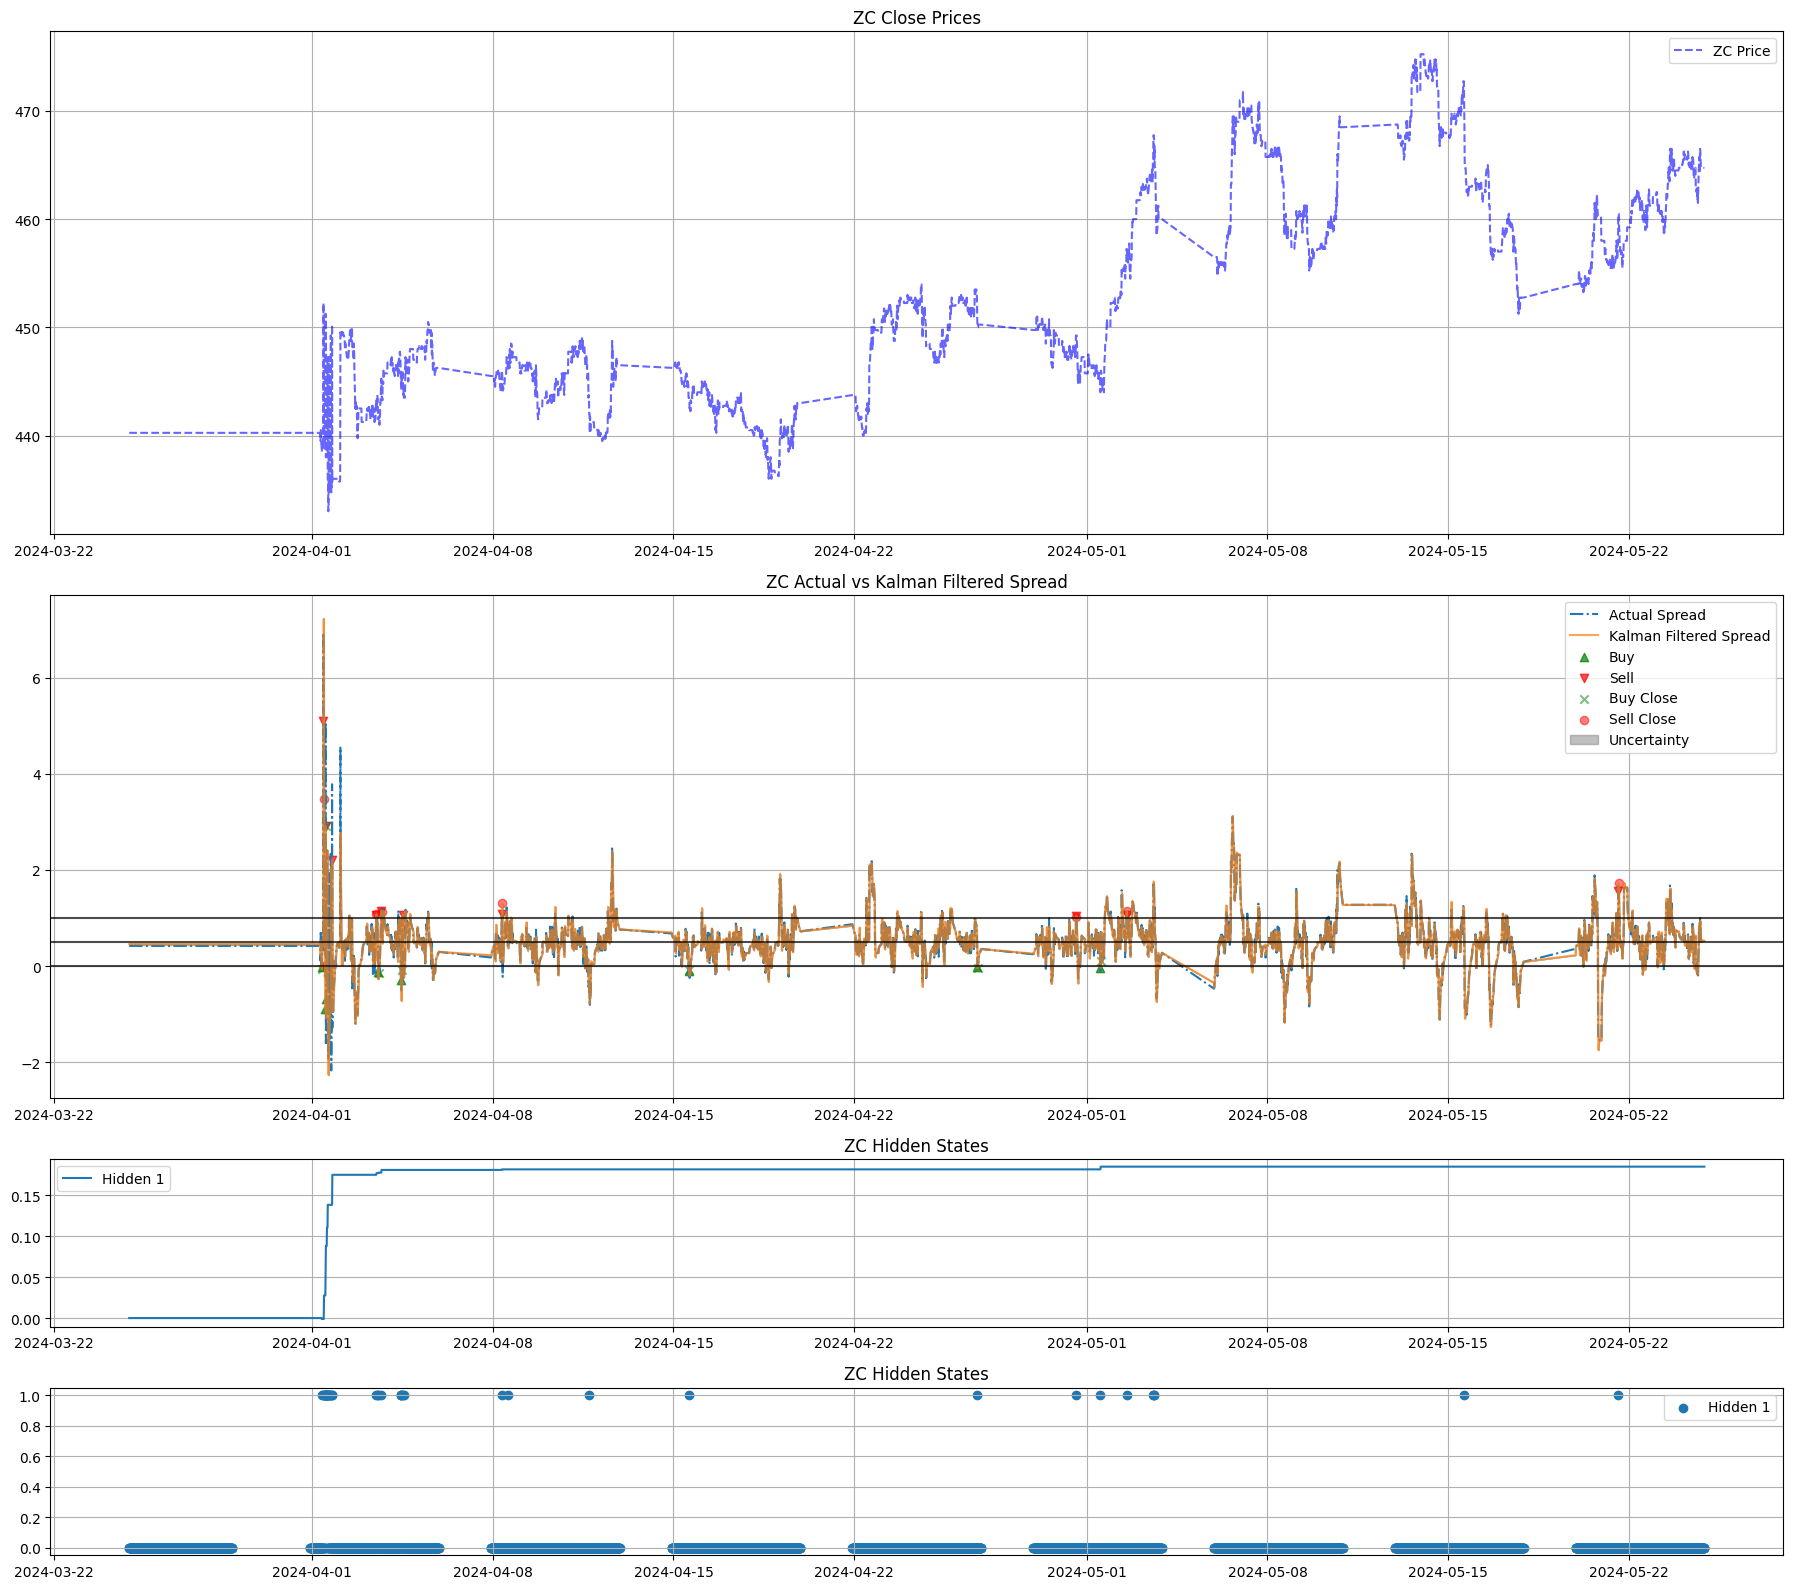

In [73]:
fig, axs = plt.subplots(4, gridspec_kw={'height_ratios': [3, 3, 1, 1]}, figsize=(18, 16))

buy_signals = big_fut_df[big_fut_df['SB'] > 0]
sell_signals = big_fut_df[big_fut_df['SS'] < 0]
long_closed = big_fut_df[big_fut_df['Closed'] > 0]
short_closed = big_fut_df[big_fut_df['Closed'] < 0]

axs[0].plot(big_fut_df['Close'].index, big_fut_df['Close'], label=f'{TARGET_FUT} Price', color='blue', alpha=0.6, linestyle='--')
axs[0].set_title(f'{TARGET_FUT} Close Prices')
axs[0].grid(True)
axs[0].legend()

# Plot the actual vs filtered spread with uncertainty tunnel
axs[1].plot(big_fut_df.index, big_fut_df['X'], label='Actual Spread', linestyle="-.")
axs[1].plot(big_fut_df.index, big_fut_df['Filtered_X'], label='Kalman Filtered Spread', alpha=0.7)
axs[1].scatter(buy_signals.index, buy_signals[f'Filtered_X'], color='green', marker='^', label='Buy', alpha =0.7)
axs[1].scatter(sell_signals.index, sell_signals[f'Filtered_X'], color='red', marker='v', label='Sell', alpha =0.7)
axs[1].scatter(long_closed.index, long_closed[f'Filtered_X'], color='green', marker='x', label='Buy Close', alpha =0.5)
axs[1].scatter(short_closed.index, short_closed[f'Filtered_X'], color='red', marker='o', label='Sell Close', alpha =0.5)
axs[1].fill_between(big_fut_df.index,
                    big_fut_df['Filtered_X'] - big_fut_df['Uncertainty'],
                    big_fut_df['Filtered_X'] + big_fut_df['Uncertainty'],
                    label='Uncertainty', color="gray", alpha=0.5)
axs[1].axhline(y=1., color='black', alpha=0.7)
axs[1].axhline(y=0.5, color='black', alpha=0.7)
axs[1].axhline(y=0., color='black', alpha=0.7)
axs[1].set_title(f'{TARGET_FUT} Actual vs Kalman Filtered Spread')
axs[1].legend()
axs[1].grid(True)

# Plot the residuals
axs[2].plot(big_fut_df.index, big_fut_df['cRets'], label='Hidden 1')
axs[2].set_title(f'{TARGET_FUT} Hidden States')
axs[2].grid(True)
axs[2].legend()

axs[3].scatter(big_fut_df.index, big_fut_df[META_LABEL], label='Hidden 1')
axs[3].set_title(f'{TARGET_FUT} Hidden States')
axs[3].grid(True)
axs[3].legend()

plt.tight_layout()
plt.show()

### Other Future

In [91]:
TARGET_FUT = SOYBEAN_FUT.replace('=F', '')

HALF_LIFE, HURST = get_ou(target_fut_df, f"{TARGET_FUT}_Close")

window = abs(HALF_LIFE)
bb_df = signal_kf_bollinger_bands(target_fut_df, f"{TARGET_FUT}_Close", f"{TARGET_FUT}_Volume", std_factor=modulate_std(HURST))

spread = bb_df["%B"].bfill().ffill()
volumes = target_fut_df[f"{TARGET_FUT}_Volume"].to_numpy()
prices = target_fut_df[f"{TARGET_FUT}_Close"].to_numpy()

assert not np.isnan(spread).any() and not np.isnan(volumes).any()

big_fut_df, _, _ = dynamic_support_resistance(futs_df, f"{TARGET_FUT}_Close", f"{TARGET_FUT}_High",f"{TARGET_FUT}_Low",window_size=HALF_LIFE)
kf_df, _ = kalman_backtest(spread, volumes, prices, period=INTERVAL)

big_fut_df = pd.concat([big_fut_df, kf_df], axis=1).bfill().ffill()
big_fut_df.tail(5)

100%|██████████| 3802/3802 [00:05<00:00, 676.24it/s]
kalman_backtest: 3802it [00:03, 1024.15it/s]


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Spread,CL_Open,CL_High,CL_Low,CL_Close,...,SB,SS,SBS,SSB,Closed,Position,Ret,Unreal_Ret,cRets,Drawdown
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-24 21:01:00+00:00,4.463,4.463,4.458,4.458,48.0,0.005,77.790001,77.940002,77.769997,77.889999,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.053376,-0.016629
2024-05-24 21:16:00+00:00,4.463,4.463,4.458,4.458,48.0,0.005,77.790001,77.940002,77.769997,77.889999,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.053376,-0.016629
2024-05-24 21:31:00+00:00,4.463,4.463,4.458,4.458,48.0,0.005,77.790001,77.940002,77.769997,77.889999,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.053376,-0.016629
2024-05-24 21:46:00+00:00,4.463,4.463,4.458,4.458,48.0,0.005,77.790001,77.940002,77.769997,77.889999,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.053376,-0.016629
2024-05-24 22:00:00+00:00,4.463,4.463,4.458,4.458,48.0,0.005,77.790001,77.940002,77.769997,77.889999,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.053376,-0.016629


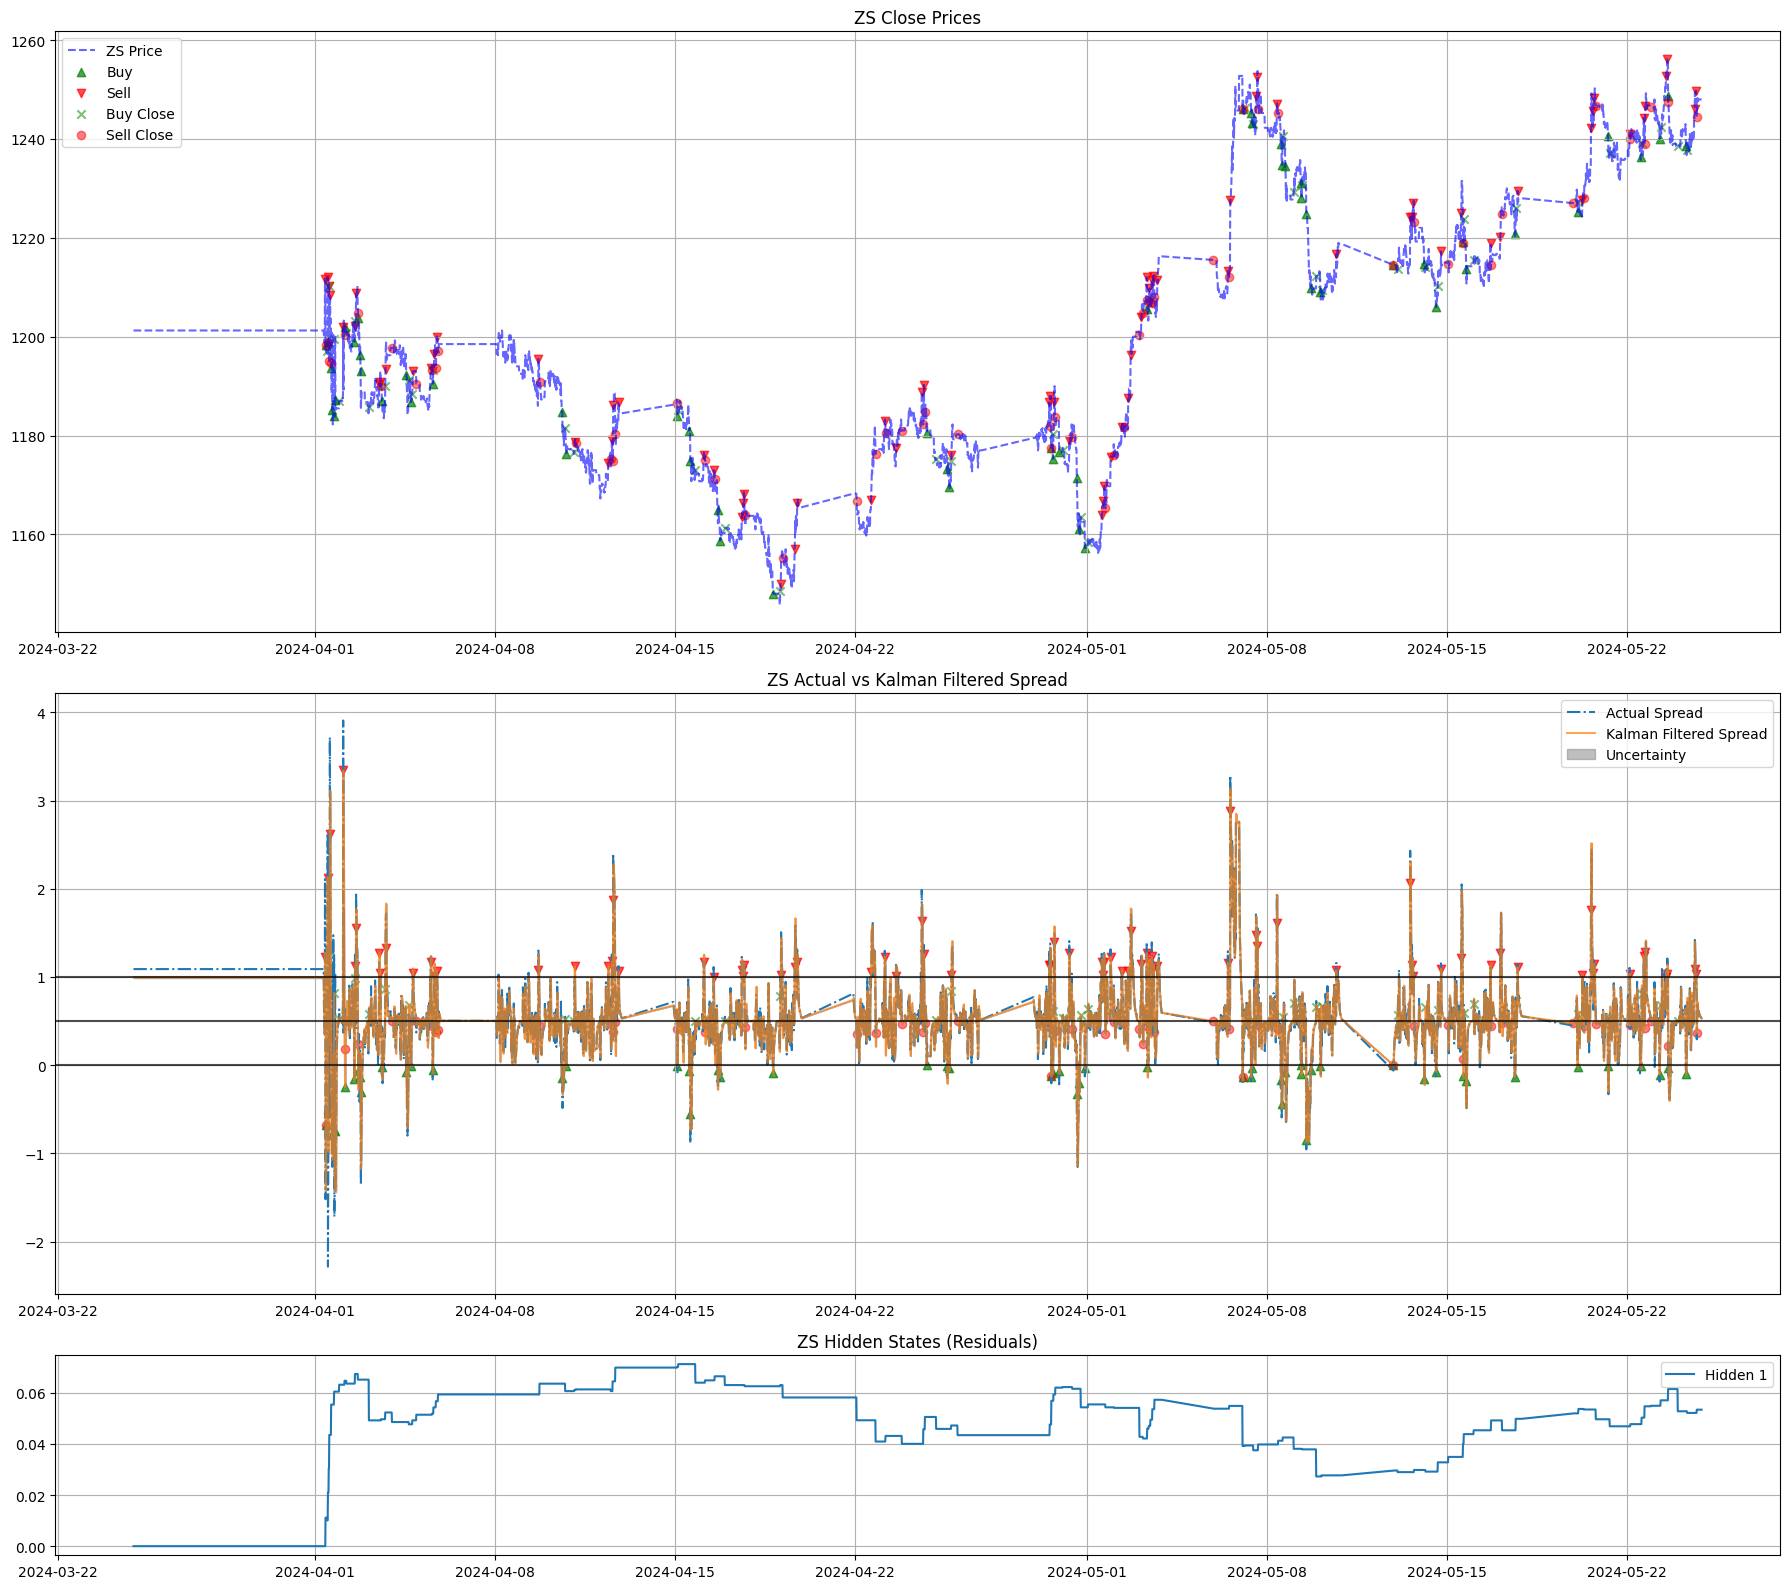

In [92]:
fig, axs = plt.subplots(3, gridspec_kw={'height_ratios': [3, 3, 1]}, figsize=(18, 16))

buy_signals = big_fut_df[big_fut_df['SB'] > 0]
sell_signals = big_fut_df[big_fut_df['SS'] < 0]
long_closed = big_fut_df[big_fut_df['Closed'] > 0]
short_closed = big_fut_df[big_fut_df['Closed'] < 0]

# Plot Close Prices
axs[0].plot(big_fut_df.index, big_fut_df['Close'], label=f'{TARGET_FUT} Price', color='blue', alpha=0.6, linestyle='--')
axs[0].set_title(f'{TARGET_FUT} Close Prices')
axs[0].scatter(buy_signals.index, buy_signals['Close'], color='green', marker='^', label='Buy', alpha=0.7)
axs[0].scatter(sell_signals.index, sell_signals['Close'], color='red', marker='v', label='Sell', alpha=0.7)
axs[0].scatter(long_closed.index, long_closed['Close'], color='green', marker='x', label='Buy Close', alpha=0.5)
axs[0].scatter(short_closed.index, short_closed['Close'], color='red', marker='o', label='Sell Close', alpha=0.5)
axs[0].grid(True)
axs[0].legend()

# Plot Actual vs Filtered Spread
axs[1].plot(big_fut_df.index, big_fut_df['X'], label='Actual Spread', linestyle="-.")
axs[1].plot(big_fut_df.index, big_fut_df['Filtered_X'], label='Kalman Filtered Spread', alpha=0.7)
axs[1].scatter(buy_signals.index, buy_signals['Filtered_X'], color='green', marker='^', alpha=0.7)
axs[1].scatter(sell_signals.index, sell_signals['Filtered_X'], color='red', marker='v', alpha=0.7)
axs[1].scatter(long_closed.index, long_closed['Filtered_X'], color='green', marker='x', alpha=0.5)
axs[1].scatter(short_closed.index, short_closed['Filtered_X'], color='red', marker='o', alpha=0.5)
axs[1].fill_between(big_fut_df.index,
                    big_fut_df['Filtered_X'] - big_fut_df['Uncertainty'],
                    big_fut_df['Filtered_X'] + big_fut_df['Uncertainty'],
                    label='Uncertainty', color="gray", alpha=0.5)
axs[1].axhline(y=1., color='black', alpha=0.7)
axs[1].axhline(y=0.5, color='black', alpha=0.7)
axs[1].axhline(y=0., color='black', alpha=0.7)
axs[1].set_title(f'{TARGET_FUT} Actual vs Kalman Filtered Spread')
axs[1].legend()
axs[1].grid(True)

# Plot Hidden States (Residuals)
axs[2].plot(big_fut_df.index, big_fut_df['cRets'], label='Hidden 1')
axs[2].set_title(f'{TARGET_FUT} Hidden States (Residuals)')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

In [93]:
position = 0
start_index = None

big_fut_df['Ret'] = 0
big_fut_df['Closed'] = 0
big_fut_df['Position'] = 0
big_fut_df['Unreal_Ret'] = 0
big_fut_df['cRets'] = 0
for i, row in tqdm(big_fut_df.iterrows(), desc="kalman_backtest"):
    mr_potential = best_model.predict([row[SELECTED_FEATURES]])[0]
    big_fut_df.loc[i, META_LABEL] = mr_potential

    if ((row['SBS'] == -1 and position == 1) or \
        (row['SSB'] == 1 and position == -1) or \
        (position == 1 and row['Close'] <= entry * (1 - 0.1)) or \
        (position == -1 and row['Close'] >= entry * (1 + 0.1))):

        if position == 1:
            big_fut_df.loc[i, 'Ret'] = (row['Close'] - entry) / entry
            big_fut_df.loc[i, 'Closed'] = 1
        else:
            big_fut_df.loc[i, 'Ret'] = (entry - row['Close']) / entry
            big_fut_df.loc[i, 'Closed'] = -1
        position = 0
    elif ((row['SBS'] == 1 and position == 0) or (row['SSB'] == -1 and position == 0)):
        # it was cancelled.
        big_fut_df.loc[i, 'SBS'] = big_fut_df.loc[i, 'SSB'] = 0

    if ((row['SB'] == 1 and position == 0) or (row['SS'] == -1 and position == 0)):
        if mr_potential:
            entry = row['Close']
            position = 1 if row['SB'] == 1 else -1
        else:
            big_fut_df.loc[i, 'SB'] = big_fut_df.loc[i, 'SS'] = 0

    big_fut_df.loc[i, 'Position'] = position
    if position != 0:
        # Unrealized for continuous returns tracking.
        big_fut_df.loc[i, 'Unreal_Ret'] = (entry - row['Close']) / entry

        if not mr_potential:
            if position == 1:
                big_fut_df.loc[i, 'Ret'] = (row['Close'] - entry) / entry
                big_fut_df.loc[i, 'Closed'] = 1
                big_fut_df.loc[i, 'SBS'] = 1
            else:
                big_fut_df.loc[i, 'Ret'] = (entry - row['Close']) / entry
                big_fut_df.loc[i, 'Closed'] = -1
                big_fut_df.loc[i, 'SSB'] = 1
            position = 0

big_fut_df['cRets'] = (1 + big_fut_df['Ret']).cumprod() - 1

kalman_backtest: 0it [00:00, ?it/s]

kalman_backtest: 4224it [00:13, 311.59it/s]


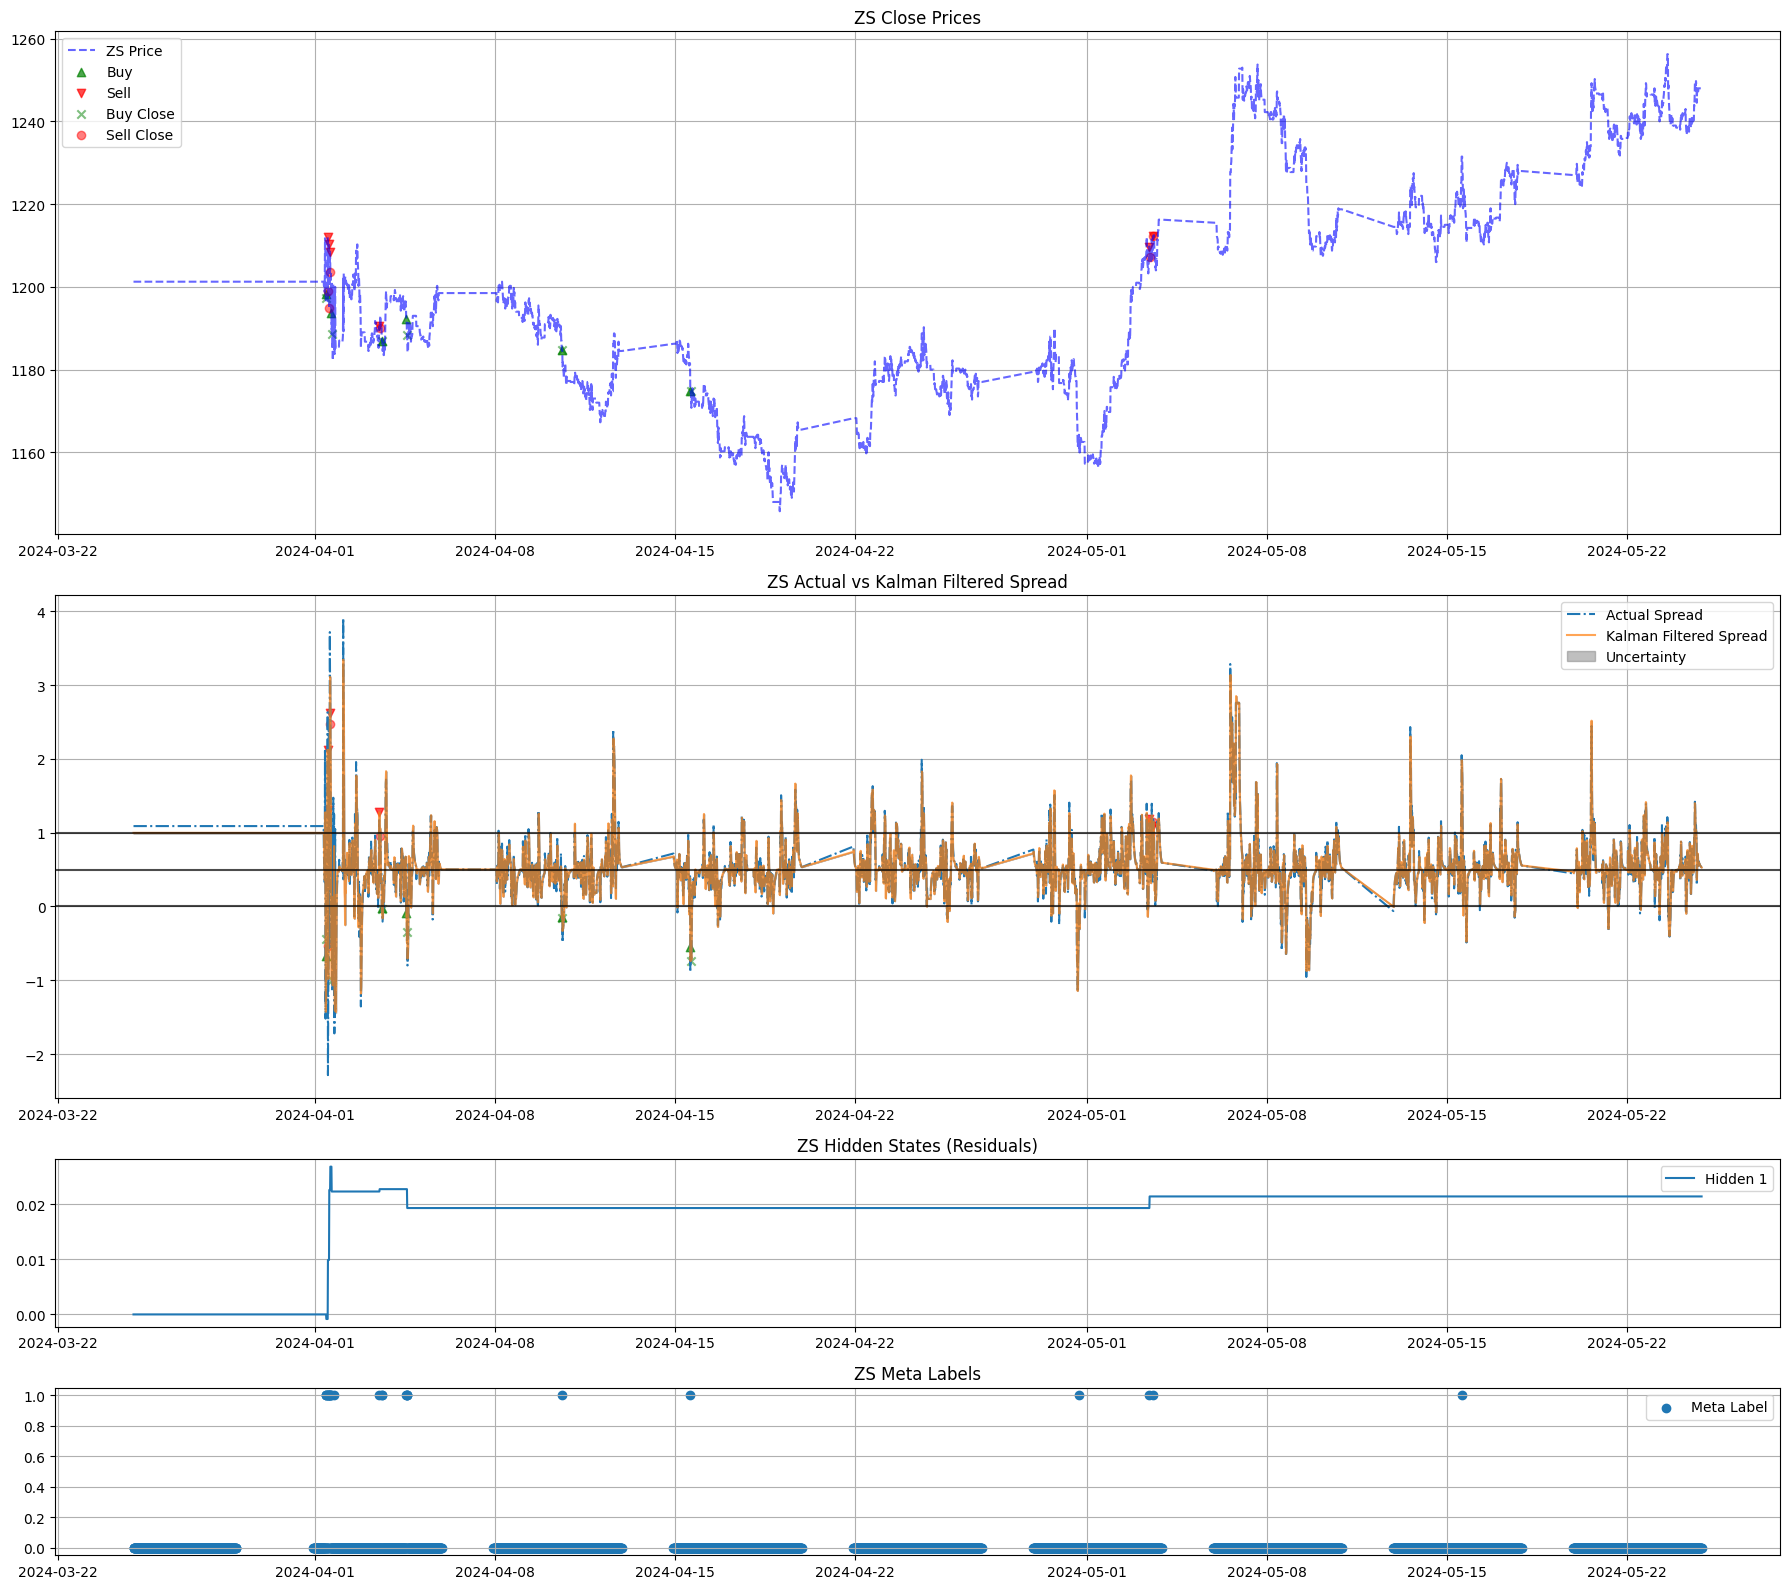

In [94]:
fig, axs = plt.subplots(4, gridspec_kw={'height_ratios': [3, 3, 1, 1]}, figsize=(18, 16))

buy_signals = big_fut_df[big_fut_df['SB'] > 0]
sell_signals = big_fut_df[big_fut_df['SS'] < 0]
long_closed = big_fut_df[big_fut_df['Closed'] > 0]
short_closed = big_fut_df[big_fut_df['Closed'] < 0]

# Plot Close Prices
axs[0].plot(big_fut_df.index, big_fut_df['Close'], label=f'{TARGET_FUT} Price', color='blue', alpha=0.6, linestyle='--')
axs[0].set_title(f'{TARGET_FUT} Close Prices')
axs[0].scatter(buy_signals.index, buy_signals['Close'], color='green', marker='^', label='Buy', alpha=0.7)
axs[0].scatter(sell_signals.index, sell_signals['Close'], color='red', marker='v', label='Sell', alpha=0.7)
axs[0].scatter(long_closed.index, long_closed['Close'], color='green', marker='x', label='Buy Close', alpha=0.5)
axs[0].scatter(short_closed.index, short_closed['Close'], color='red', marker='o', label='Sell Close', alpha=0.5)
axs[0].grid(True)
axs[0].legend()

# Plot Actual vs Filtered Spread
axs[1].plot(big_fut_df.index, big_fut_df['X'], label='Actual Spread', linestyle="-.")
axs[1].plot(big_fut_df.index, big_fut_df['Filtered_X'], label='Kalman Filtered Spread', alpha=0.7)
axs[1].scatter(buy_signals.index, buy_signals['Filtered_X'], color='green', marker='^', alpha=0.7)
axs[1].scatter(sell_signals.index, sell_signals['Filtered_X'], color='red', marker='v', alpha=0.7)
axs[1].scatter(long_closed.index, long_closed['Filtered_X'], color='green', marker='x', alpha=0.5)
axs[1].scatter(short_closed.index, short_closed['Filtered_X'], color='red', marker='o', alpha=0.5)
axs[1].fill_between(big_fut_df.index,
                    big_fut_df['Filtered_X'] - big_fut_df['Uncertainty'],
                    big_fut_df['Filtered_X'] + big_fut_df['Uncertainty'],
                    label='Uncertainty', color="gray", alpha=0.5)
axs[1].axhline(y=1., color='black', alpha=0.7)
axs[1].axhline(y=0.5, color='black', alpha=0.7)
axs[1].axhline(y=0., color='black', alpha=0.7)
axs[1].set_title(f'{TARGET_FUT} Actual vs Kalman Filtered Spread')
axs[1].legend()
axs[1].grid(True)

# Plot Hidden States (Residuals)
axs[2].plot(big_fut_df.index, big_fut_df['cRets'], label='Hidden 1')
axs[2].set_title(f'{TARGET_FUT} Hidden States (Residuals)')
axs[2].grid(True)
axs[2].legend()

# Plot Meta Labels
axs[3].scatter(big_fut_df.index, big_fut_df[META_LABEL], label='Meta Label')
axs[3].set_title(f'{TARGET_FUT} Meta Labels')
axs[3].grid(True)
axs[3].legend()

plt.tight_layout()
plt.show()
